# Xarray `open_mfdataset()` approach

This is a notebook demonstrates working with Sentinel-1 RTC imagery that has been processsed on the ASF On-Demand server and downloaded locally. 

The access point for data in this notebook is a directory containing un-zipped directories of RTC scenes.
```{note}
worth including image of directory structure here?
```

This tutorial contains examples of two approaches to working with locally-downloaded ASF-processed Sentinel-1 RTC imagery. This notebook will detail how to use the xarray function `xr.open_mfdataset()`. While this approach works and is very useful for working with large stacks of data with associated metadata, you will also see an example of the limitations of this approach due to certain characteristics of the dataset. You can read more about `xr.open_mfdataset()` [here](https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html).

**Learning goals**:

Handling large amounts of locally stored data
- organize large set of geotiff files stored locally
- multiple methods for reading data into python as `xarray` objects
    - xarray `open_mfdataset()`

## Software and setup

In [1]:
import os
import xarray as xr
import rioxarray as rio
import geopandas as gpd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask

from pathlib import Path
from intake.source.utils import reverse_format


We'll use this function later but defining it now:

In [2]:
def points2coords(pt_ls): #should be [xmin, ymin, xmax, ymax]
    
    coords_ls = [(pt_ls[0], pt_ls[1]), (pt_ls[0], pt_ls[3]),
                 (pt_ls[2], pt_ls[3]), (pt_ls[2], pt_ls[1]),
                 (pt_ls[0], pt_ls[1])]
    return coords_ls
    



Initialize a `dask.distributed` client:

```{note} 
On my local machine, I ran into issues initially when the cluster was running on processes rather than threads. This caused system memory issues and many dead kernels. Setting `processes=False` seemed to fix these issues
```

In [3]:
from dask.distributed import Client

client = Client(processes=False) #look into limiting memory
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.86.35:8787/status,
Dashboard: http://192.168.86.35:8787/status,Workers: 1
Total threads: 16,Total memory: 14.96 GiB
Status: running,Using processes: False
Comm: inproc://192.168.86.35/210008/1,Workers: 1
Dashboard: http://192.168.86.35:8787/status,Total threads: 16
Started: Just now,Total memory: 14.96 GiB
Comm: inproc://192.168.86.35/210008/4,Total threads: 16
Dashboard: http://192.168.86.35:36477/status,Memory: 14.96 GiB
Nanny: None,


Open the dask dashboard at the link above to monitor task progress.

### Organize file paths

Set up some string variables for directory paths. We need to pass `xr.open_mfdataset()` a list of all files to read in. Currently, the file structure is organized so that each scene has its own sub-directory within `unzipped_keep`. Within each sub-directory are several files - we want to extract the tif files containing RTC imagery for the VV and VH polarizations for each scene as well as the layover-shadow mask for each scene. The function `extract_tif_fnames()` takes a path to the directory containing the sub-directories for all scenes and returns a list of the filenames for VV-polarization tif files, VH-polarization tif files and layover-shadow mask tif files. 

In [4]:
dir_path_all = '/home/emmamarshall/Desktop/siparcs/asf_rtc_data/unzipped_keep/' #rename this
scenes_ls = os.listdir(dir_path_all)

def extract_tif_fnames(scene_path):
    ''' given a path to an individual S1 scene, return a list of files associated with a single S1 scene'''
    scene_files_ls = os.listdir(dir_path_all + scene_path)
    
    scene_files_vv = [fname for fname in scene_files_ls if fname.endswith('_VH.tif')]
    scene_files_vh = [fname for fname in scene_files_ls if fname.endswith('_VV.tif')]
    scene_files_ls = [fname for fname in scene_files_ls if fname.endswith('_ls_map.tif')]
    
    return scene_files_vv, scene_files_vh, scene_files_ls

Now we need to attach the filenames to the full path to each file. We will end up with a list of full paths to all three tif files for each scene in the stack.

In [16]:
fpaths_vv, fpaths_vh, fpaths_ls = [],[],[]

for element in range(len(scenes_ls)):
    
    good_files = extract_tif_fnames(scenes_ls[element])
    
    path_vh = dir_path_all + scenes_ls[element] + '/' + good_files[0][0]
    path_vv = dir_path_all + scenes_ls[element] + '/' + good_files[1][0]
    path_ls = dir_path_all + scenes_ls[element] + '/' + good_files[2][0]
    
    fpaths_vv.append(path_vv)
    fpaths_vh.append(path_vh)
    fpaths_ls.append(path_ls)

In [5]:
data_dir = '/home/emmamarshall/Desktop/siparcs/asf_rtc_data/unzipped_keep/'

In [6]:
fpaths_vv = list(Path(data_dir).rglob('*VV.tif'))
fpaths_vh = list(Path(data_dir).rglob('*VH.tif'))
fpaths_ls = list(Path(data_dir).rglob('*ls_map.tif'))

## Read in files using `xr.open_mfdataset()`

The `xr.open_mfdataset()` function reads multiple files (in a directory or from a list) and combines them to return a single `xr.Dataset` or `xr.DataArray`. To use the function, specify parameters such as how the files should be combined as well as any preprocessing to execute on the original files. This example will demonstrate a workflow for using `open_mfdataset()` to read in three stacks of roughly 100 RTC images.

`preprocess_vv`, `preprocess_vh`  and `preprocess_ls` are identical but for vv and vh bands (read from different tif files). `preprocess_ls` reads in the layover shadow masks that are provided with each scene and similarly stored as tiff files.


```{note}
can the preprocess fn take input parameters in addition to the ds? if so consider combining these into one preprocess function with an input parameter for variable (VV, VH, LS)?
```

In [25]:
fpaths_vv_sub = fpaths_vv[:4]
fpaths_vv_sub

[PosixPath('/home/emmamarshall/Desktop/siparcs/asf_rtc_data/unzipped_keep/S1A_IW_20210821T000314_DVP_RTC30_G_gpuned_748F_(1)/S1A_IW_20210821T000314_DVP_RTC30_G_gpuned_748F_VV.tif'),
 PosixPath('/home/emmamarshall/Desktop/siparcs/asf_rtc_data/unzipped_keep/S1A_IW_20220116T120547_DVP_RTC30_G_gpuned_0D1E_(1)/S1A_IW_20220116T120547_DVP_RTC30_G_gpuned_0D1E_VV.tif'),
 PosixPath('/home/emmamarshall/Desktop/siparcs/asf_rtc_data/unzipped_keep/S1A_IW_20210708T120545_DVP_RTC30_G_gpuned_3E89_(1)/S1A_IW_20210708T120545_DVP_RTC30_G_gpuned_3E89_VV.tif'),
 PosixPath('/home/emmamarshall/Desktop/siparcs/asf_rtc_data/unzipped_keep/S1A_IW_20220422T120547_DVP_RTC30_G_gpuned_61B6_(1)/S1A_IW_20220422T120547_DVP_RTC30_G_gpuned_61B6_VV.tif')]

In [26]:
ds1 = xr.open_dataset(fpaths_vv[0])

In [32]:
def preprocess_vv(da_orig):
#def preprocess(da_orig, var_name):
    '''function that should return an xarray object with time dimension and associated metadata given a path to a single RTC scene, if its dualpol will have multiple bands, currently just as 2 data arrays but could merge.
    goal would be to apply this a list of directories for different RTC products, return cube along time dimension - I think? 
    - for concatenating, would need to check footprints and only take products with the same footprint, or subset them all to a common AOI? '''

    
    da = da_orig.copy()
    da = da.rename({'band_data':'vv'}).squeeze()
    #da = da.rename({'band_data':f'{var_name}'}).squeeze()
    
    #we want to extract important metadata from the tif filenames
    #use the 'source' key from the encoding dictionary to attach the filename
    vv_fn = os.path.basename(da_orig['band_data'].encoding['source'])#[113:]
    
    #extract relevant metadata
    sensor = vv_fn[0:3]
    beam_mode = vv_fn[4:6]
    acq_date_raw = vv_fn[7:15] #need to parse further
    acq_date = datetime.strptime(acq_date_raw, '%Y%m%d')
    acq_time = vv_fn[15:22]
    pol_type = vv_fn[24:25] # dual pol ...
    primary_pol = vv_fn[25:26] # VV ...
    orbit_type = vv_fn[26:27] #Precise (P), Restituted (R), or Original Predicted (O)
    terrain_correction_pixel_spacing = vv_fn[27:32] #Terrain Correction Pixel Spacing
    rtc_alg = vv_fn[33:34] #Software Package Used: GAMMA (G)
    output = vv_fn[35] #  Gamma-0 (g) or Sigma-0 (s) Output
    output_type = vv_fn[36] #Power (p) or Decibel (d) or Amplitude (a) Output
    masked = vv_fn[37]  #Unmasked (u) or Water Masked (w)
    filtered = vv_fn[38]  # Not Filtered (n) or Filtered (f)
    area =  vv_fn[39]       # Entire Area (e) or Clipped Area (c)
    tbd =   vv_fn[40]   #Dead Reckoning (d) or DEM Matching (m)
    product_id  = vv_fn[42:46]  #Product ID
    
    #combine metadata into dictionary that will be used to assign attrs
    attrs_dict = { 'sensor': sensor,
                    'beam_mode':beam_mode, 
                    'acquisition_date' : acq_date,
                    'acquisition_time': acq_time,
                    'polarisation_type': pol_type,
                    'primary_polarisation': primary_pol,
                    'orbit_type': orbit_type,
                    'terrain_correction_pixel_spacing' : terrain_correction_pixel_spacing,
                    'output_format': output,
                    'output_type': output_type,
                    'masked' : masked,
                    'filtered':filtered,
                    'area':area,
                    'product_id': product_id 
             }
                    
    #link the strings for each of the above variables to their full names (from README, commented above)
    #eg if output_type=g, should read 'gamma'
    #add these as attrs to xr obj, make into dict first? 
    # parse acq_date to datetime, add as dim and coordinate to xr obj
    #add other metadata vars as attributes to xr obj
    
    da.attrs = attrs_dict
    
    utm_zone = da.spatial_ref.attrs['crs_wkt'][17:29]
    epsg_code =da.spatial_ref.attrs['crs_wkt'][589:594]
    
    da.attrs['utm_zone'] = utm_zone
    da.attrs['epsg_code'] = f'EPSG:{epsg_code}'
    
    date = da.attrs['acquisition_date']
    
    da = da.assign_coords({'acq_date':date})
    da = da.expand_dims('acq_date')
    da = da.drop_duplicates(dim=['x','y'])
    
    return da

Repeat for the other two variables (unless these can be combined into one preprocess?)

In [39]:
def preprocess_vh(da_orig):
    '''function that should return an xarray object with time dimension and associated metadata given a path to a single RTC scene, if its dualpol will have multiple bands, currently just as 2 data arrays but could merge.
    goal would be to apply this a list of directories for different RTC products, return cube along time dimension - I think? 
    - for concatenating, would need to check footprints and only take products with the same footprint, or subset them all to a common AOI? '''
    
    #fname_ls = []
    
    da = da_orig.copy()
    da = da.rename({'band_data':'vh'}).squeeze()
   
    #vv_fn = da_orig.encoding['source'][113:]
    vv_fn = os.path.basename(da_orig['band_data'].encoding['source'])
    print('fname: ', vv_fn)
    
    sensor = vv_fn[0:3]
    beam_mode = vv_fn[4:6]
    acq_date_raw = vv_fn[7:15] #need to parse further
    acq_date = datetime.strptime(acq_date_raw, '%Y%m%d')
    acq_time = vv_fn[15:22]
    pol_type = vv_fn[24:25] # dual pol ...
    primary_pol = vv_fn[25:26] # VV ...
    orbit_type = vv_fn[26:27] #Precise (P), Restituted (R), or Original Predicted (O)
    terrain_correction_pixel_spacing = vv_fn[27:32] #Terrain Correction Pixel Spacing
    rtc_alg = vv_fn[33:34] #Software Package Used: GAMMA (G)
    output = vv_fn[35] #  Gamma-0 (g) or Sigma-0 (s) Output
    output_type = vv_fn[36] #Power (p) or Decibel (d) or Amplitude (a) Output
    masked = vv_fn[37]  #Unmasked (u) or Water Masked (w)
    filtered = vv_fn[38]  # Not Filtered (n) or Filtered (f)
    area =  vv_fn[39]       # Entire Area (e) or Clipped Area (c)
    tbd =   vv_fn[40]   #Dead Reckoning (d) or DEM Matching (m)
    product_id  = vv_fn[42:46]  #Product ID
    
    attrs_dict = { 'sensor': sensor,
                    'beam_mode':beam_mode, 
                    'acquisition_date' : acq_date,
                    'acquisition_time': acq_time,
                    'polarisation_type': pol_type,
                    'primary_polarisation': primary_pol,
                    'orbit_type': orbit_type,
                    'terrain_correction_pixel_spacing' : terrain_correction_pixel_spacing,
                    'output_format': output,
                    'output_type': output_type,
                    'masked' : masked,
                    'filtered':filtered,
                    'area':area,
                    'product_id': product_id 
             }
                    
    #link the strings for each of the above variables to their full names (from README, commented above)
    #eg if output_type=g, should read 'gamma'
    #add these as attrs to xr obj, make into dict first? 
    # parse acq_date to datetime, add as dim and coordinate to xr obj
    #add other metadata vars as attributes to xr obj
    
    da.attrs = attrs_dict
    
    utm_zone = da.spatial_ref.attrs['crs_wkt'][17:29]
    epsg_code =da.spatial_ref.attrs['crs_wkt'][589:594]
    
    da.attrs['utm_zone'] = utm_zone
    da.attrs['epsg_code'] = f'EPSG:{epsg_code}'
    
    date = da.attrs['acquisition_date']
    
    da = da.assign_coords({'acq_date':date})
    da = da.expand_dims('acq_date')
    da = da.drop_duplicates(dim=['x','y'])
    
    return da #, fname_ls

In [36]:
def preprocess_ls(da_orig):
    '''function that should return an xarray object with time dimension and associated metadata given a path to a single RTC scene, if its dualpol will have multiple bands, currently just as 2 data arrays but could merge.
    goal would be to apply this a list of directories for different RTC products, return cube along time dimension - I think? 
    - for concatenating, would need to check footprints and only take products with the same footprint, or subset them all to a common AOI? '''

    
    da = da_orig.copy()
    da = da.rename({'band_data':'layover_shadow_mask'}).squeeze()
    
    vv_fn = da_orig.encoding['source'][113:]
    print(vv_fn)
    
    sensor = vv_fn[0:3]
    beam_mode = vv_fn[4:6]
    acq_date_raw = vv_fn[7:15] #need to parse further
    acq_date = datetime.strptime(acq_date_raw, '%Y%m%d')
    acq_time = vv_fn[15:22]
    pol_type = vv_fn[24:25] # dual pol ...
    primary_pol = vv_fn[25:26] # VV ...
    orbit_type = vv_fn[26:27] #Precise (P), Restituted (R), or Original Predicted (O)
    terrain_correction_pixel_spacing = vv_fn[27:32] #Terrain Correction Pixel Spacing
    rtc_alg = vv_fn[33:34] #Software Package Used: GAMMA (G)
    output = vv_fn[35] #  Gamma-0 (g) or Sigma-0 (s) Output
    output_type = vv_fn[36] #Power (p) or Decibel (d) or Amplitude (a) Output
    masked = vv_fn[37]  #Unmasked (u) or Water Masked (w)
    filtered = vv_fn[38]  # Not Filtered (n) or Filtered (f)
    area =  vv_fn[39]       # Entire Area (e) or Clipped Area (c)
    tbd =   vv_fn[40]   #Dead Reckoning (d) or DEM Matching (m)
    product_id  = vv_fn[42:46]  #Product ID
    
    attrs_dict = { 'sensor': sensor,
                    'beam_mode':beam_mode, 
                    'acquisition_date' : acq_date,
                    'acquisition_time': acq_time,
                    'polarisation_type': pol_type,
                    'primary_polarisation': primary_pol,
                    'orbit_type': orbit_type,
                    'terrain_correction_pixel_spacing' : terrain_correction_pixel_spacing,
                    'output_format': output,
                    'output_type': output_type,
                    'masked' : masked,
                    'filtered':filtered,
                    'area':area,
                    'product_id': product_id 
             }
                    
    #link the strings for each of the above variables to their full names (from README, commented above)
    #eg if output_type=g, should read 'gamma'
    #add these as attrs to xr obj, make into dict first? 
    # parse acq_date to datetime, add as dim and coordinate to xr obj
    #add other metadata vars as attributes to xr obj
    
    da.attrs = attrs_dict
    
    utm_zone = da.spatial_ref.attrs['crs_wkt'][17:29]
    epsg_code =da.spatial_ref.attrs['crs_wkt'][589:594]
    
    da.attrs['utm_zone'] = utm_zone
    da.attrs['epsg_code'] = f'EPSG:{epsg_code}'
    
    date = da.attrs['acquisition_date']
    
    da = da.assign_coords({'acq_date':date})
    da = da.expand_dims('acq_date')
    da = da.drop_duplicates(dim=['x','y'])
    
    #vec = gpd.read_file('https://github.com/e-marshall/s1_book/raw/main/data/hma_lakes_aoi.geojson')
    #print(vec.crs)
    #da_clip = da.rio.clip(vec.geometry, vec.crs, drop=True)
    #print(da_clip.crs)
    
    return da

First, let's call `xr.open_mfdataset()` with the argument `chunks='auto'`. This will read in a dask array where ideal chunk sizes are selected based off the array size, it will attempt to have chunk sizes where bytes are equal to the configuration value for array chunk size. More about that [here](https://docs.dask.org/en/stable/array-chunks.html#automatic-chunking).You can check the configuration value for an array chunk size with the code below: 

In [37]:
dask.config.get('array.chunk-size')

'128MiB'

In [40]:
asf_vh = xr.open_mfdataset(paths = fpaths_vh, preprocess = preprocess_vh, chunks = 'auto', engine='rasterio', data_vars='minimal', coords='minimal', concat_dim='acq_date', combine='nested', parallel=True)

fname: fname:  S1A_IW_20210610T000310_DVP_RTC30_G_gpuned_AC38_VH.tif
fname:  S1A_IW_20211017T121357_DVP_RTC30_G_gpuned_F9A9_VH.tif
 S1A_IW_20210821T000314_DVP_RTC30_G_gpuned_748F_VH.tif
fname:  S1A_IW_20220317T120545_DVP_RTC30_G_gpuned_C890_VH.tif
fname:  S1A_IW_20211223T120548_DVP_RTC30_G_gpuned_5413_VH.tif
fname:  S1A_IW_20211005T121357_DVP_RTC30_G_gpuned_BEAB_VH.tif
fname:  S1A_IW_20220221T120546_DVP_RTC30_G_gpuned_5D96_VH.tif
fname:  S1A_IW_20220403T121418_DVP_RTC30_G_gpuned_57F2_VH.tif
fname:  S1A_IW_20210622T000310_DVP_RTC30_G_gpuned_D48F_VH.tif
fname:  S1A_IW_20211008T000315_DVP_RTC30_G_gpuned_68EA_VH.tif
fname: fname:  S1A_IW_20210701T121417_DVP_RTC30_G_gpuned_65E0_VH.tif
 S1A_IW_20220415T121353_DVP_RTC30_G_gpuned_6270_VH.tif
fname:  S1A_IW_20220109T121354_DVP_RTC30_G_gpuned_485C_VH.tif
fname:  S1A_IW_20220305T120545_DVP_RTC30_G_gpuned_056C_VH.tif
fname:  S1A_IW_20210911T121356_DVP_RTC30_G_gpuned_3A2A_VH.tif
fname: fname:  S1A_IW_20211125T000315_DVP_RTC30_G_gpuned_199D_VH.tif
f

In [35]:
asf_vh

,Array,Chunk
Bytes,89.59 GiB,73.81 MiB
Shape,"(103, 13379, 17452)","(1, 3921, 4935)"
Count,1338 Graph Layers,317240 Chunks
Type,float32,numpy.ndarray


If we take a look at the `asf_vh` object we just created (click the stack icon on the right of the `vh` variable tab), we see that the chunking is quite complicated. This isn't ideal because it can create problems like excessive communication between workers (?) (and a lot of memory usage) down the line when we perform non-lazy operations. It seems like the `'auto'` chunking is applied to the top layer (file) of the dataset, but because the spatial footprint of each file is not the same, the 'auto' chunking does not persist through layers and we end up with the funky layout in the object above. 

Let's create both the VV and VH objects with `chunks=None` and see how it looks:

In [34]:
asf_vh = xr.open_mfdataset(paths = fpaths_vh, preprocess = preprocess_vh, chunks = None, engine='rasterio', data_vars='minimal', coords='minimal', concat_dim='acq_date', combine='nested', parallel=True)

In [35]:
asf_vh

<xarray.Dataset>
Dimensions:      (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 2.907e+06 2.907e+06 ... 3.309e+06 3.309e+06
  * acq_date     (acq_date) datetime64[ns] 2021-08-21 2022-01-16 ... 2022-04-06
    band         int64 1
    spatial_ref  int64 0
Data variables:
    vh           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
Attributes: (12/16)
    sensor:                            S1A
    beam_mode:                         IW
    acquisition_date:                  2021-08-21 00:00:00
    acquisition_time:                  T000314
    polarisation_type:                 V
    primary_polarisation:              P
    ...                                ...
    masked:                            u
    filtered:                          n
    area:                              e
    product_id:                        748F
    utm_zone:                          UTM zone 45N
    epsg_code:                         EPSG:32645

nan

In [33]:
asf_vv= xr.open_mfdataset(paths = fpaths_vv, preprocess = preprocess_vv, chunks = None, engine='rasterio', data_vars='minimal', coords='minimal', concat_dim='acq_date', combine='nested', parallel=True)

In [20]:
asf_ls = xr.open_mfdataset(paths = fpaths_ls, preprocess = preprocess_ls, chunks=None, engine='rasterio', data_vars='minimal', coords='minimal', concat_dim = 'acq_date', combine='nested', parallel=True)


Now our chunks are quite large, but they are at least in a format that makes more sense for our dataset. This will make it easier to clip the object to our area of interest, which will solve the problem of large chunks

In [21]:
asf_vv

<xarray.Dataset>
Dimensions:      (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 2.907e+06 2.907e+06 ... 3.309e+06 3.309e+06
  * acq_date     (acq_date) datetime64[ns] 2021-08-21 2022-01-16 ... 2022-04-06
    band         int64 1
    spatial_ref  int64 0
Data variables:
    vv           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
Attributes: (12/16)
    sensor:                            S1A
    beam_mode:                         IW
    acquisition_date:                  2021-08-21 00:00:00
    acquisition_time:                  T000314
    polarisation_type:                 V
    primary_polarisation:              P
    ...                                ...
    masked:                            u
    filtered:                          n
    area:                              e
    product_id:                        748F
    utm_zone:                          UTM zone 45N
    epsg_code:                         EPSG:32645

In [22]:
asf_vh

<xarray.Dataset>
Dimensions:      (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 2.907e+06 2.907e+06 ... 3.309e+06 3.309e+06
  * acq_date     (acq_date) datetime64[ns] 2021-08-21 2022-01-16 ... 2022-04-06
    band         int64 1
    spatial_ref  int64 0
Data variables:
    vh           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
Attributes: (12/16)
    sensor:                            S1A
    beam_mode:                         IW
    acquisition_date:                  2021-08-21 00:00:00
    acquisition_time:                  T000314
    polarisation_type:                 V
    primary_polarisation:              P
    ...                                ...
    masked:                            u
    filtered:                          n
    area:                              e
    product_id:                        748F
    utm_zone:                          UTM zone 45N
    epsg_code:                         EPSG:32645

In [23]:
asf_ls

<xarray.Dataset>
Dimensions:              (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x                    (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y                    (y) float64 2.907e+06 2.907e+06 ... 3.309e+06 3.309e+06
  * acq_date             (acq_date) datetime64[ns] 2021-08-21 ... 2022-04-06
    band                 int64 1
    spatial_ref          int64 0
Data variables:
    layover_shadow_mask  (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
Attributes: (12/16)
    sensor:                            S1A
    beam_mode:                         IW
    acquisition_date:                  2021-08-21 00:00:00
    acquisition_time:                  T000314
    polarisation_type:                 V
    primary_polarisation:              P
    ...                                ...
    masked:                            u
    filtered:                          n
    area:                              e
    product_id:                        748F
    utm_zone:                          UTM zone 45N
    epsg_code:                         EPSG:32645

Merge the VH, VV and layover-shadow mask objects into one `xr.Dataset`:

In [24]:
asf_ds = xr.Dataset({'vv':asf_vv.vv, 'vh':asf_vh.vh, 'ls':asf_ls.layover_shadow_mask})
asf_ds

<xarray.Dataset>
Dimensions:      (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 2.907e+06 2.907e+06 ... 3.309e+06 3.309e+06
  * acq_date     (acq_date) datetime64[ns] 2021-08-21 2022-01-16 ... 2022-04-06
    band         int64 1
    spatial_ref  int64 0
Data variables:
    vv           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
    vh           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
    ls           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>

If you take a look at the `acq_date` coordinate, you will see that they are not in order. Let's sort by the `acq_date` (time) dimension using xarray `.sortby()`:

In [25]:
asf_ds_sorted = asf_ds.sortby(asf_ds.acq_date)
asf_ds_sorted

<xarray.Dataset>
Dimensions:      (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x            (x) float64 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 2.907e+06 2.907e+06 ... 3.309e+06 3.309e+06
  * acq_date     (acq_date) datetime64[ns] 2021-05-02 2021-05-05 ... 2022-05-21
    band         int64 1
    spatial_ref  int64 0
Data variables:
    vv           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
    vh           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>
    ls           (acq_date, y, x) float32 dask.array<chunksize=(1, 13379, 17452), meta=np.ndarray>

## Clip stack to AOI using `rioxarray.clip()`

This is a pretty unwieldly object (nearly 200 GB). Let's subset it down to just the area we want to focus on. Read in the following GeoJSON to clip the dataset to the area of interest we'll be using in this tutorial. This AOI covers a region in the central Himalaya near the Chinese border. We will use the `rioxarray.clip()` function which you can read more about [here](https://corteva.github.io/rioxarray/stable/examples/clip_geom.html).

```{note} 
provide more background on region/AOI here, plus use  cartopy to add basemap to the plot of AOI?
```

In [9]:
pc_aoi = gpd.read_file('https://github.com/e-marshall/sentinel1_rtc/raw/main/hma_rtc_aoi.geojson')
pc_aoi

,geometry
0,"POLYGON ((619420.000 3089790.000, 628100.000 3..."


<AxesSubplot:>

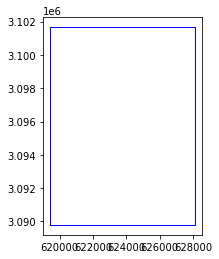

In [27]:
pc_aoi.plot(facecolor='None', edgecolor='blue')

In [28]:
asf_clip = asf_ds_sorted.rio.clip(pc_aoi.geometry, pc_aoi.crs)

Check the size of the clipped object:

In [29]:
asf_clip.nbytes/1e6

141.948568

In [33]:
#we don't want to compute this right now, will kill kernel
#asf_clip_load = asf_clip.compute()

The dataset is published as gamma-nought values on the power scale. This is useful for performing statistical analysis but not always for visualization. We convert to decibel scale (sigma-nought) in order to visualize variability in backscatter more easily. Read more about scales used to represent SAR data [here](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#sar-scales).

In [10]:
def power_to_db(input_arr):
    return (10*np.log10(np.abs(input_arr)))

NameError: name 'asf_clip' is not defined

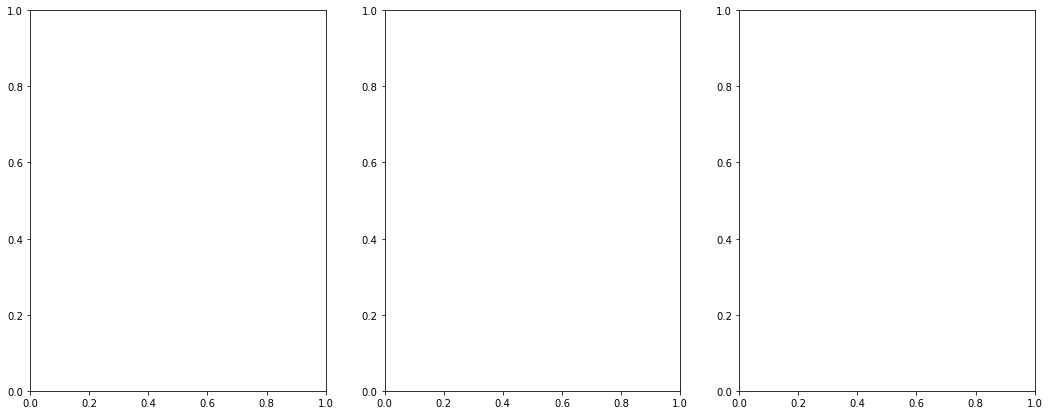

In [12]:
fig, axs = plt.subplots(ncols=3, figsize=(18,7))

asf_clip.isel(acq_date=10).ls.plot(ax=axs[0]);
power_to_db(asf_clip.isel(acq_date=10).vv).plot(ax=axs[1], cmap = plt.cm.Greys_r);
power_to_db(asf_clip.isel(acq_date=10).vh).plot(ax=axs[2], cmap = plt.cm.Greys_r);

fig.suptitle(f'Layover-shadow mask (L), VV (C) and VH (R) backscatter on {str(asf_clip.isel(acq_date=10).acq_date.data)[:-19]}');

## Wrap-up

The `xr.open_mfdataset()` approach is very useful for reading in large amounts of data from a number of distributed files very efficiently. It's especially helpful that the `preprocess()` function allows a large degree of customization for how the data is read in, and that the appropriate metadata is preserved as individual `xr.DataArrays` are organized into data cubes and we have to do very little further work of organizing metadata. 

However, due to the nature of this stack of data, where each time-element of the stack covers a common region of interest but does not have a uniform spatial footprint (re-word), this approach is not very computationally efficient. We are reading in a vast footprint of data to subset it to a much smaller area. While it is able to execute on this machine, a more computationally-intensive workflow would fail. 

Another approach we can try is to use gdal VRT objects. Gdal vrt objects create an xml file from a list of geotiff files. The xml contains a mapping of all of the specified raster files so that we essentially have the spatial information that would have been used to create the full data object, and all of the information we need for a clip. VRT objects are able to handle the mismatch of grids within the stack of files, so does not encounter the memory issues that we get when trying the `xr.open_mfdataset()` approach with dask. 